**Import Dependencies**

In [1]:
import os
from PIL import Image 
import random
import numpy as np
import pickle
import random
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tqdm.notebook import tqdm

from keras import backend as k
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator ,img_to_array
from keras.models import Sequential,Model
from keras.layers import Dense,Flatten,Conv2D,MaxPooling2D,AveragePooling2D,Dropout,BatchNormalization,Activation
from keras.activations import relu,softmax
from keras.initializers import he_normal,glorot_normal,random_normal,glorot_uniform
from keras.losses import categorical_crossentropy
from keras.optimizers import Adadelta,Adam
from keras.utils import np_utils
from keras.preprocessing.image import load_img
from keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings('ignore')

**Get the imagefile in the current directory**

In [2]:
! wget https://storage.googleapis.com/wandb_datasets/nature_12K.zip
! unzip '/content/nature_12K.zip'

Streaming output truncated to the last 5000 lines.
  inflating: inaturalist_12K/train/Arachnida/1ac25349af662e85f577a31f64beca41.jpg  
  inflating: inaturalist_12K/train/Arachnida/117ef7f1812725f359500448a258e713.jpg  
  inflating: inaturalist_12K/train/Arachnida/6409254954c3b46d88d64f0bf4c632fa.jpg  
  inflating: inaturalist_12K/train/Arachnida/aaed865750bd52944658a7dd23366948.jpg  
  inflating: inaturalist_12K/train/Arachnida/460cc09ef510d400a4d47a836ddd45e6.jpg  
  inflating: inaturalist_12K/train/Arachnida/55c48c3afef0b745e53951284cdb2db4.jpg  
  inflating: inaturalist_12K/train/Arachnida/bff3daa961ee96a37ebe12dc0bcce504.jpg  
  inflating: inaturalist_12K/train/Arachnida/9082d4f2107bccf1f14d71c8944be607.jpg  
  inflating: inaturalist_12K/train/Arachnida/93d0130423d42f7c6228150eb95a2a93.jpg  
  inflating: inaturalist_12K/train/Arachnida/051aba6d7bc324bad76bd438ed3cc276.jpg  
  inflating: inaturalist_12K/train/Arachnida/67595af09c015c7753d5d4935677590f.jpg  
  inflating: inaturalist_

In [3]:
class CNN_M:

  def __init__(self,input_shape,target_size ,num_filters,filter_size,fo,num_neurons,data_aug,dropout,BN,num_outputs):
    self.model = Sequential()
    self.input_shape = input_shape
    self.target_size = target_size
    self.num_filters = num_filters
    self.filter_size = filter_size
    self.fo = fo
    self.num_neurons =num_neurons
    self.data_aug = data_aug
    self.dropout = dropout
    self.BN = BN
    self.num_outputs = num_outputs

  def BUILD_MODEL(self):
    
    #Build 1st layer...
    self.model.add(Conv2D(filters = self.num_filters ,kernel_size =self.filter_size,use_bias = True,
                          input_shape=self.input_shape))
    self.model.add(Activation('relu'))
    self.model.add(MaxPooling2D(pool_size=(2,2)))

    cf = self.num_filters 
    for i in range(1,5):
      cf*=self.fo
      self.model.add(Conv2D(filters = cf , kernel_size = self.filter_size ,use_bias= True))
      if self.BN == 'Yes':
        self.model.add(BatchNormalization(axis = -1))

      self.model.add(Activation('relu'))
      self.model.add(Dropout(self.dropout))
      self.model.add(MaxPooling2D(pool_size=(2,2)))

    self.model.add(Flatten())
    self.model.add(Dense(units=self.num_neurons))
    
    if self.BN == 'Yes':
      self.model.add(BatchNormalization(axis = -1))
    
    self.model.add(Activation('relu'))
    self.model.add(Dropout(self.dropout))

    self.model.add(Dense(units = self.num_outputs ,activation='softmax'))

    self.model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])
    return 


  #Fit model using the train datagenerator and returns fitted model..
  def fit_CNN(self , train_path ,epochs ,batch_size):

    
    if self.data_aug == 1:
      tr_datagen = ImageDataGenerator(rescale=1./255,validation_split = 0.1,
                                      zoom_range=0.2 ,horizontal_flip=True ,rotation_range=30 ,shear_range=12)
    else:
      tr_datagen = ImageDataGenerator(rescale=1./255,
                             validation_split = 0.1)
    
    tr_gen = tr_datagen.flow_from_directory(
        directory = train_path,target_size = self.target_size,color_mode = 'rgb',       
        batch_size = batch_size,
        class_mode = 'categorical',
        shuffle = True,
        seed = 10,
        subset = 'training'
        )

    val_gen = tr_datagen.flow_from_directory(
        directory = train_path,target_size = self.target_size,color_mode = 'rgb',
        batch_size = batch_size,
        class_mode = 'categorical',
        shuffle = True,
        seed = 10,
        subset = 'validation'
        ) 
      
    #Fitting The model...
    step_size_train = tr_gen.n//tr_gen.batch_size
    step_size_valid = val_gen.n//val_gen.batch_size

    self.model.fit_generator(generator = tr_gen,
                             steps_per_epoch = step_size_train,
                             validation_data = val_gen,
                             validation_steps = step_size_valid,
                             epochs = epochs, verbose=1,
                             callbacks = [EarlyStopping(monitor='val_loss',min_delta = 0.05,patience=3)])
    return 

**Train the model**

In [4]:
target_size = (224,224)
if k.image_data_format()=='channels_first':
  input_shape = (3,224,224)
else:
  input_shape = (224,224,3)

train_path = '/content/inaturalist_12K/train'

epochs =1               #If want to change epoch then can be done from here...
batch_size =64
cnn = CNN_M(input_shape = input_shape,
          target_size = target_size,      
          num_filters = 64,              #choose from values  [32,64,128]
          filter_size =3,                #choose as [3,5]
          fo = 1,                        #filter organisation [0.5 , 1 ,2] {0.5 means filters will be halved at each subsequent layers.}
          num_neurons = 64,              #number of neurons in the dense layer [32,64,128]
          data_aug = 1,                  #Data Augmentation [1,0] 1 means yes 
          dropout = 0,                   #Dropout rate [0.2,0.3] 
          BN = 'Yes',                    #Batch Normalization ['Yes' , 'No']
          num_outputs = 10)
  
cnn.BUILD_MODEL()
cnn.fit_CNN(train_path,epochs=epochs,batch_size=batch_size)

Found 9000 images belonging to 10 classes.
Found 999 images belonging to 10 classes.
140/140 [==============================] - 236s 1s/step - loss: 2.1884 - accuracy: 0.2328 - val_loss: 2.4784 - val_accuracy: 0.1583


**Get predictions for test and accuracy**

In [5]:
#Return the accuracy and predictions on test data ..

test_path = '/content/inaturalist_12K/val'
ts_datagen = ImageDataGenerator(rescale = 1./255)
test_gen = ts_datagen.flow_from_directory(
    directory = test_path,
    target_size = (224,224),
    color_mode = 'rgb',
    batch_size = 1,
    class_mode = None,
    shuffle = False,
    seed=10
    )
    
step_size_test = test_gen.n//test_gen.batch_size
test_gen.reset()

pred = cnn.model.predict_generator(generator = test_gen,
                                  steps = step_size_test,
                                  verbose = 1
                                  )
    
ypred = np.argmax(pred,axis=1)
ytrue = test_gen.classes 

print("Test accuracy", np.sum(ypred == ytrue)/len(ytrue))

Found 2000 images belonging to 10 classes.
2000/2000 [==============================] - 23s 11ms/step
Test accuracy 0.145


**plot actual vs predicted for some sample 30 images for test**

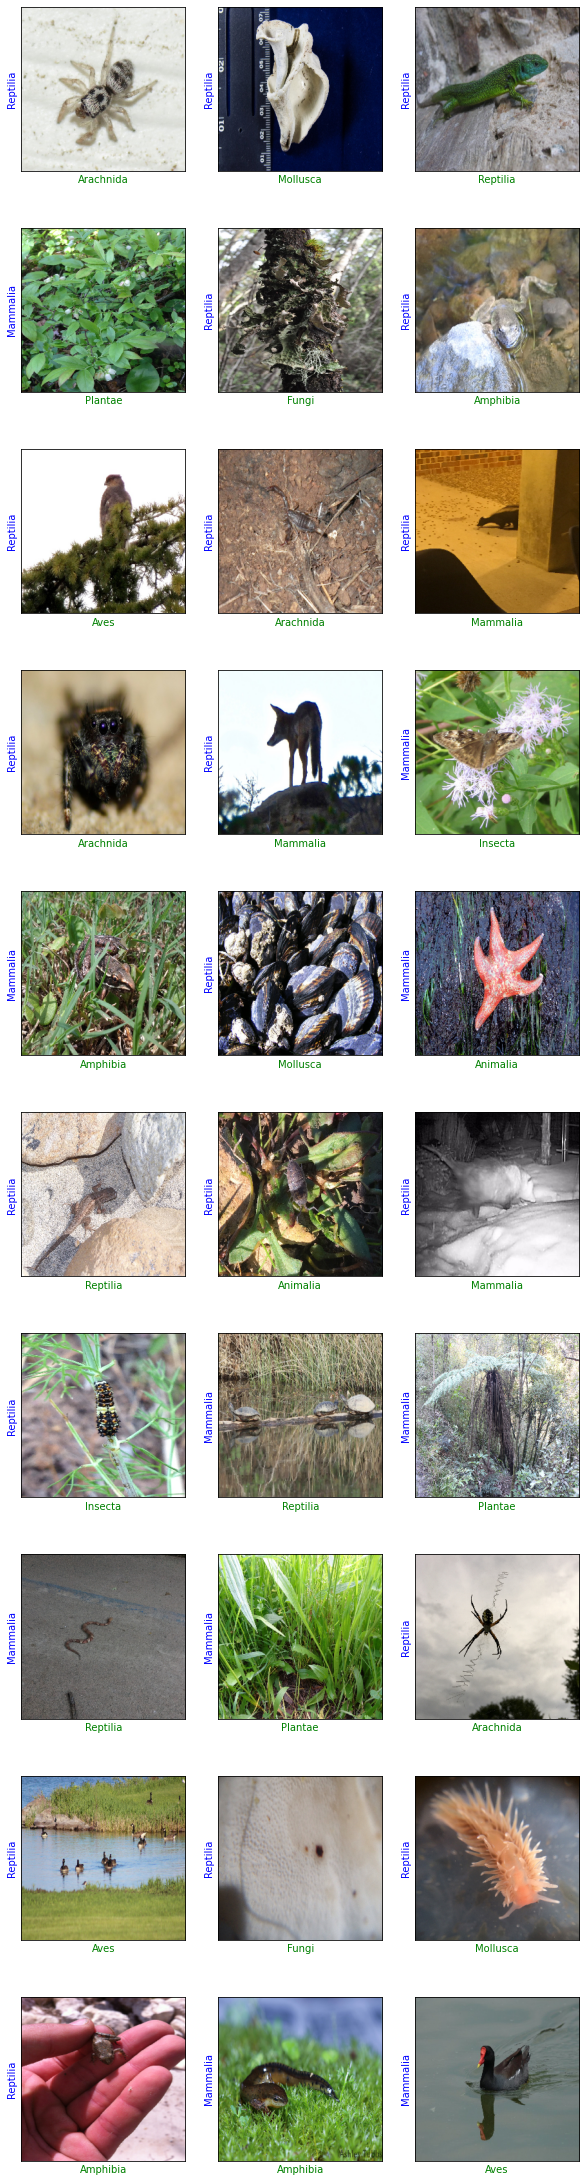

In [6]:
from keras.preprocessing.image import load_img

dict1 = test_gen.class_indices
idx_to_class = {v:k for k,v in dict1.items()}

random.seed(10)
test_image_paths = test_gen.filepaths
rnd_idx = np.random.choice(len(test_image_paths),30,replace=False)
ix=1
plt.figure(figsize=(10,40))
for idx in rnd_idx:
  ax = plt.subplot(10,3,ix)
  img = load_img(test_image_paths[idx],target_size=(256,256))
  ax.set_xticks([])
  ax.set_yticks([])
  true_label = idx_to_class[ytrue[idx]]
  pred_label = idx_to_class[ypred[idx]]

  ax.set_xlabel(true_label);ax.xaxis.label.set_color('green')
  ax.set_ylabel(pred_label);ax.yaxis.label.set_color('blue')

  plt.imshow(img)

  ix+=1
plt.show()

**visualize filters of first convolution layer**

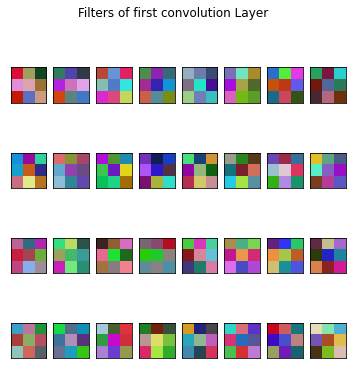

In [7]:
filters , biases = cnn.model.layers[0].get_weights()
f_min , f_max = filters.min() , filters.max()

filters = (filters - f_min)/(f_max - f_min)
n_filters ,ix = 32 ,1
#4x8 grid
plt.figure(figsize = (6,6))
for i in range(n_filters):
   f = filters[:,:,:,i]
   ax = plt.subplot(4,8,ix)
   ax.set_xticks([])
   ax.set_yticks([])
   plt.imshow(f)
   ix+=1

plt.suptitle("Filters of first convolution Layer")
plt.show()

**visualize featutre map of first convolution layer**

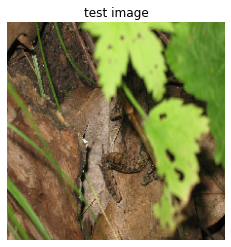

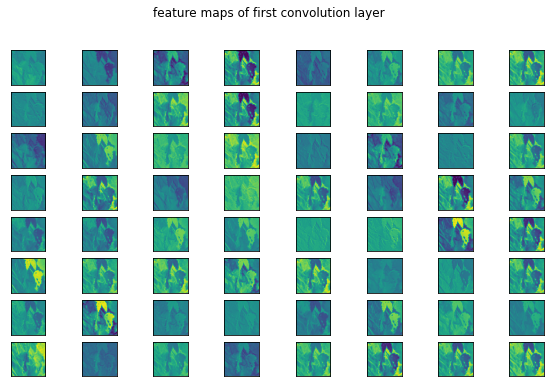

In [8]:
#feature Map for first convolution layer..
output_layer1 = cnn.model.layers[0].output
fmodel = Model(inputs = cnn.model.inputs , outputs = output_layer1)

ts_img = load_img(test_image_paths[189],target_size=(224,224))
plt.imshow(ts_img)
plt.axis('off')
plt.title('test image')
ip_img = img_to_array(ts_img)
ip_img = ip_img.reshape((1,)+ip_img.shape)
ip_img/=255.0

fmaps = fmodel.predict(ip_img)
num_fmaps = fmaps.shape[3]
ix = 1
plt.figure(figsize = (10,6))
for i in range(num_fmaps):

   ax = plt.subplot(8,8,ix)
   ax.set_xticks([])
   ax.set_yticks([])
   plt.imshow(fmaps[0,:,:,ix-1])
   ix+=1

plt.suptitle("feature maps of first convolution layer")
plt.show()

**Guided Backpropogation**

In [9]:
@tf.custom_gradient
def guidedRelu(x):
  def grad(dy):
    return tf.cast(dy>0,"float32") * tf.cast(x>0, "float32") * dy
  return tf.nn.relu(x), grad


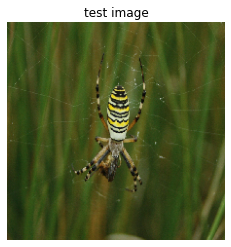

In [10]:
ts_img = load_img(test_image_paths[567],target_size=(224,224))
plt.imshow(ts_img)
plt.axis('off')
plt.title('test image')
ip_img = img_to_array(ts_img)
ip_img = ip_img.reshape((1,)+ip_img.shape)
ip_img/=255.0

In [11]:
def deprocess_image(x):
    x = x.copy()
    x -= x.mean()
    x /= (x.std() + k.epsilon())
    x *= 0.25
    x += 0.5
    x = np.clip(x, 0, 1)
    x *= 255
    if k.image_data_format() == 'channels_first':
        x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x

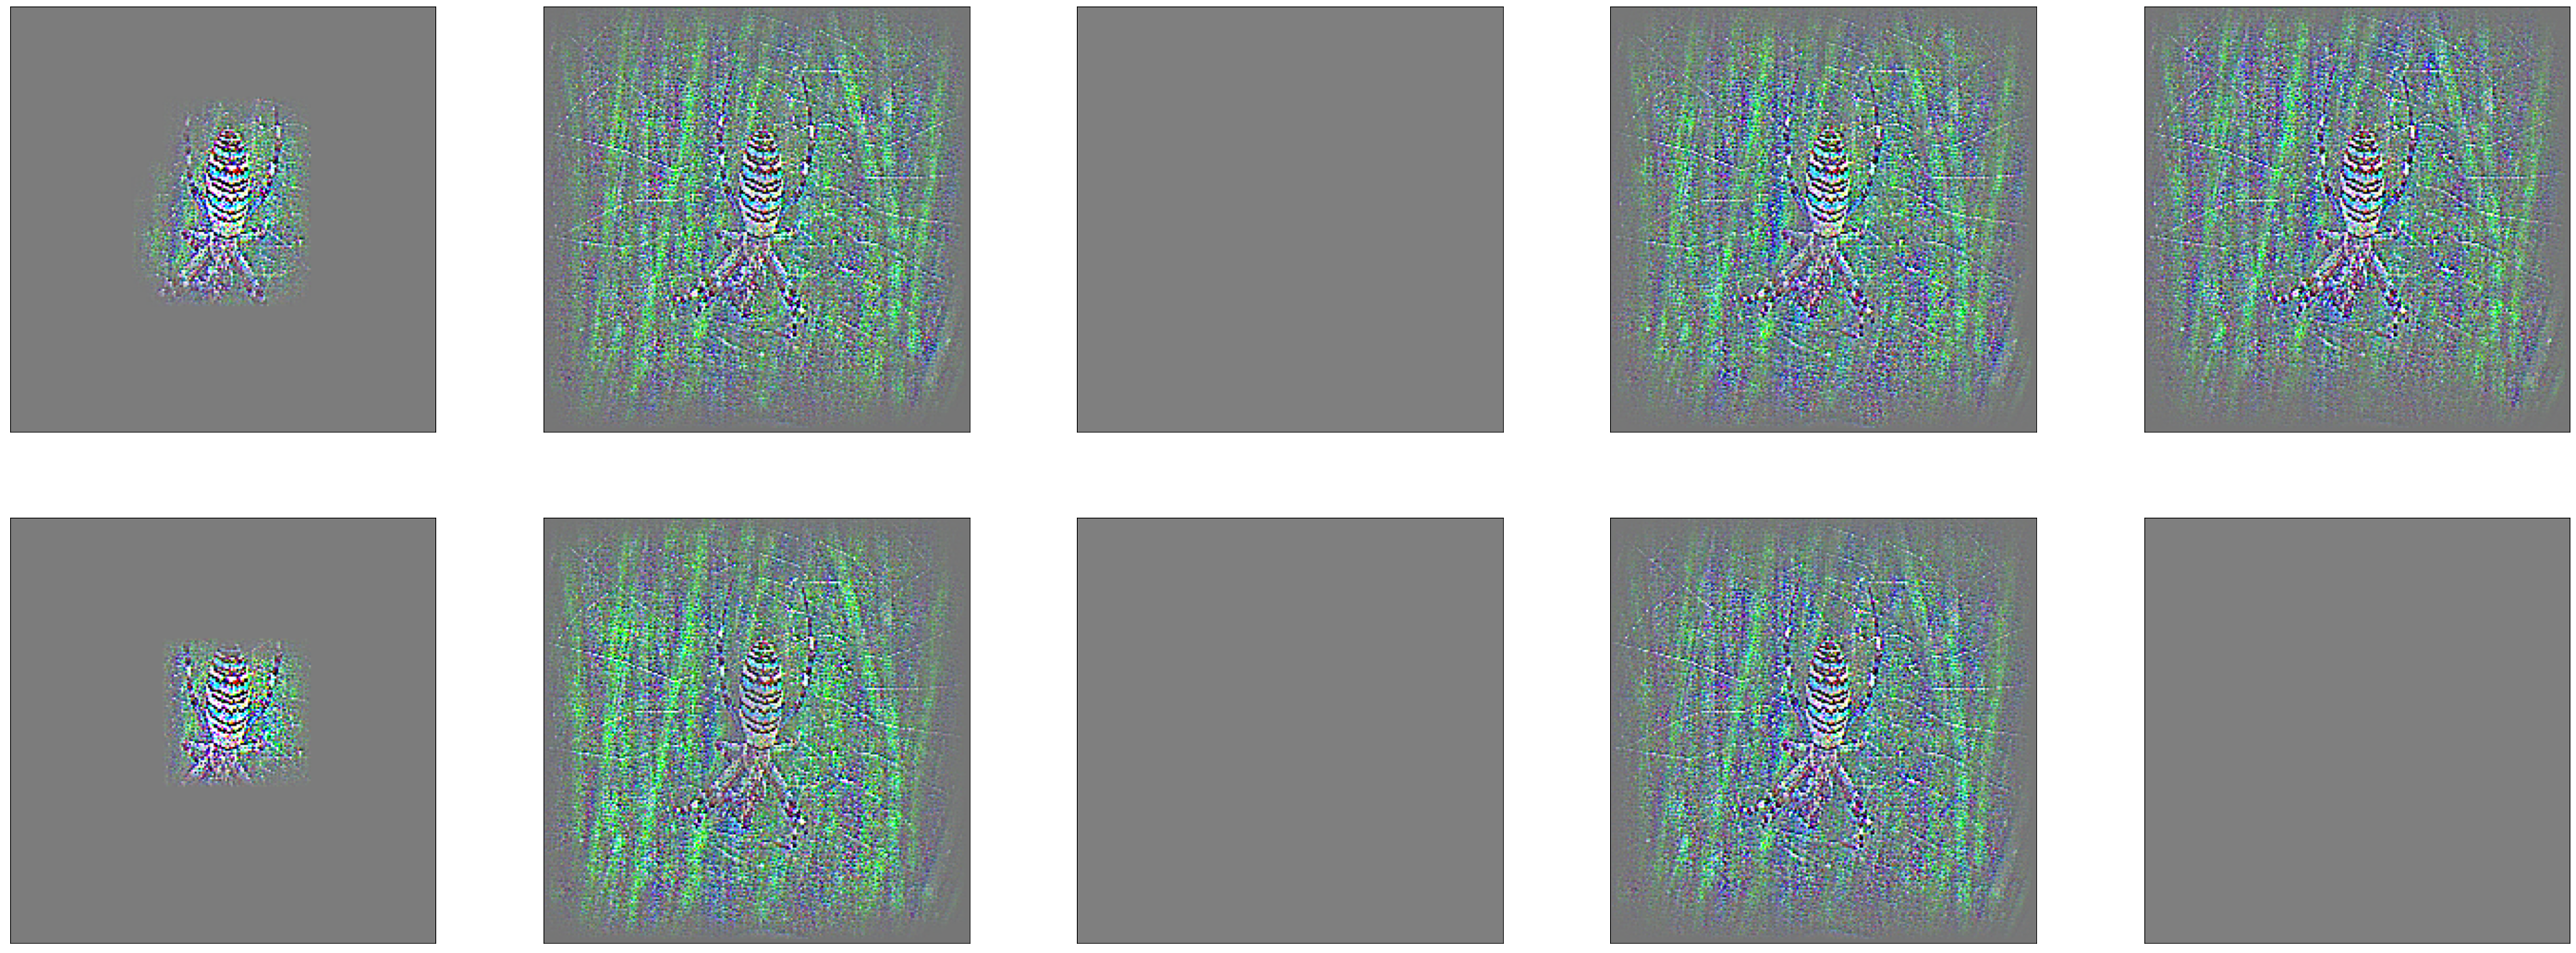

In [27]:
import random
fig = plt.figure(figsize=(50, 100))
ix=1
for i in range(10,20):
  neuronNo=random.randint(0,63)

  #20th layer is the activation layer for above architecture..
  output_layer1 = cnn.model.layers[20].output[:,:,:,neuronNo]
  gb_model=Model(inputs = cnn.model.inputs , outputs = output_layer1)
  layer_dict = [layer for layer in gb_model.layers[1:] if hasattr(layer,'activation')]
  for layer in layer_dict:
    if layer.activation == tf.keras.activations.relu:
      layer.activation = guidedRelu

  with tf.GradientTape() as tape:
    inputs = tf.cast(ip_img, tf.float32)
    tape.watch(inputs)
    outputs = gb_model(inputs)
  grads = tape.gradient(outputs,inputs)[0]
  ax = fig.add_subplot(10,5,ix)
  ax.set_xticks([])
  ax.set_yticks([])
  plt.imshow(np.flip(deprocess_image(np.array(grads)),-1))
  ix=ix+1
